# Training and Tuning Notebook

In [1]:
import sys
sys.path.insert(0, 'src')

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from data_preprocessing import *
from model import *
from train import *
from utils import *

## GPU and Mixed Precision Setup

In [2]:
gpu_setup()
mixed_precision_setup()

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
data_folder = 'data'
src_path = 'nus-cs5242'
dst_path = 'data/processed'
dataset = 'lung_ct_dataset'
train_folder = 'train'
test_folder = 'test'
train_label = 'train_label.csv'

## Image Enhancement Visualisation

1. Visualise enhanced images with varying hyperparameters.
2. Edit hyperparameters in `image_enhancement.py`.
3. Run `bash prepare_dataset.sh` to enhance images and re-generate the tensorflow dataset.

(-0.5, 1535.5, 511.5, -0.5)

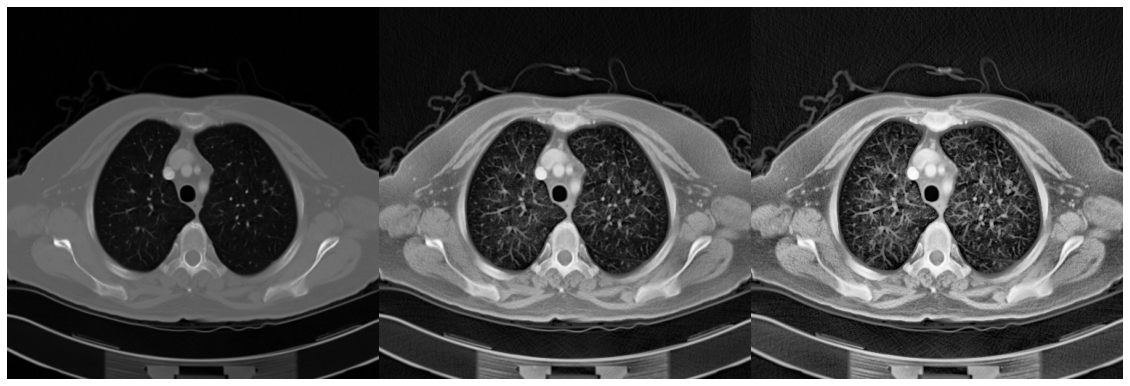

In [20]:
from image_enhancement import *


img_path = os.path.join(src_path, train_folder, '851.png')
img = cv.imread(img_path)
n_img = hist_norm(img)
clahe_img1 = clahe(img, clipLimit=4, tileGridSize=(8, 8))
clahe_img2 = clahe(img, clipLimit=8, tileGridSize=(8, 8))
# n_clahe_img = clahe(n_img, clipLimit=clip, tileGridSize=tile_size)

combined_imgs = np.hstack((img, clahe_img1, clahe_img2))
plt.figure(figsize=(20, 20))
plt.imshow(combined_imgs)
plt.axis('off')

# Single Model

## Tune Single Model Parameters

In [5]:
SEED = 0

experiment_name = 'MobileNetV2'
result_save_path = experiment_name + '_' + 'submission.csv'
model_params = {
    'model_type': 'MobileNetV2',
    'head_type': 'standard',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 5,
    'learning_rate': 1e-4,
    'dropout': 0.2
}
fine_hyperparams = {
    'num_epochs': 10,
    'learning_rate': 1e-5,
    'fine_tune_at': 100,
}

## Load Dataset

In [6]:
import tensorflow_datasets as tfds


tf.random.set_seed(SEED)

train_folds = tfds.load(
    name=dataset, 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
valid_folds = tfds.load(
    name=dataset, 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
test_ds_raw, test_info_raw = tfds.load(
    name=dataset, 
    split='test', 
    download=False, 
    shuffle_files=False, 
    as_supervised=False, 
    with_info=True,
    data_dir=data_folder
)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)

train_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['train_batch_size'], ds_type='train') for ds in train_folds ]
valid_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['valid_batch_size'], ds_type='valid') for ds in valid_folds ]
test_ds = preprocess(test_ds_raw, model_params, batch_size=base_hyperparams['test_batch_size'], ds_type='test')

In [7]:
train_valid_df = pd.read_csv(os.path.join(dst_path, train_label))
train_ds = train_folds[0]
valid_ds = valid_folds[0]

print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 17
Number of valid batches: 2
Number of test batches: 5


## K-Fold Cross Validation

Evaluate model performance.

In [11]:
tf.random.set_seed(SEED)

cross_validate(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams)

# -------------------- MobileNetV2: 1-fold -------------------- #
Epoch 1/5
 1/17 [>.............................] - ETA: 0s - loss: 1.4801 - accuracy: 0.2344WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 3s 179ms/step - loss: 1.2875 - accuracy: 0.2681 - val_loss: 1.1392 - val_accuracy: 0.3966
Epoch 2/5
17/17 [==============================] - 3s 198ms/step - loss: 1.1594 - accuracy: 0.3817 - val_loss: 1.1450 - val_accuracy: 0.3966
Epoch 3/5
17/17 [==============================] - 3s 200ms/step - loss: 1.0995 - accuracy: 0.4265 - val_loss: 1.0880 - val_accuracy: 0.4224
Epoch 4/5
17/17 [==============================]

## Train and Save Best Model

Train the cross validated model with the best parameters and save the model.

In [12]:
tf.random.set_seed(SEED)

model = feature_extract_and_fine_tune(experiment_name, train_ds, valid_ds, model_params, base_hyperparams, fine_hyperparams)
predicted_labels = evaluate(model, test_ds)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
save_results(img_ids, predicted_labels, result_save_path)
save_model(model, experiment_name)

Epoch 1/5
17/17 [==============================] - 5s 315ms/step - loss: 1.3074 - accuracy: 0.2500 - val_loss: 1.1395 - val_accuracy: 0.3966
Epoch 2/5
17/17 [==============================] - 3s 151ms/step - loss: 1.1570 - accuracy: 0.4074 - val_loss: 1.1416 - val_accuracy: 0.3966
Epoch 3/5
17/17 [==============================] - 3s 179ms/step - loss: 1.0918 - accuracy: 0.4332 - val_loss: 1.0823 - val_accuracy: 0.4310
Epoch 4/5
17/17 [==============================] - 4s 206ms/step - loss: 1.0646 - accuracy: 0.4494 - val_loss: 1.0432 - val_accuracy: 0.4741
Epoch 5/5
17/17 [==============================] - 3s 204ms/step - loss: 1.0061 - accuracy: 0.5172 - val_loss: 1.0062 - val_accuracy: 0.5345
Number of layers in the base model:  155
Epoch 6/15
17/17 [==============================] - 5s 280ms/step - loss: 0.8422 - accuracy: 0.6479 - val_loss: 0.7748 - val_accuracy: 0.7155
Epoch 7/15
17/17 [==============================] - 4s 239ms/step - loss: 0.6567 - accuracy: 0.7739 - val_loss: 

# Ensemble Model

## Tune Ensemble Model Parameters

In [13]:
SEED = 0

experiment_name = 'Ensemble'
result_save_path = experiment_name + '_' + 'submission.csv'
model_params = {
    'model_names': ['Xception', 'MobileNetV2', 'ResNet152V2'],
    'head_type': 'ensemble',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 5,
    'learning_rate': 1e-4,
    'hidden_units': 10
}

## Modify dataset

Convert dataset to support multiple models with multiple inputs

In [14]:
tf.random.set_seed(SEED)

train_ds = train_ds.concatenate(valid_ds)  # train on entire dataset

train_ds = preprocess_ensemble(train_ds, model_params)
valid_ds = preprocess_ensemble(valid_ds, model_params)
test_ds = preprocess_ensemble(test_ds, model_params)

## Train and Evaluate Ensemble

In [15]:
tf.random.set_seed(SEED)

ensemble_model = ensemble_learn(
    experiment_name, train_ds, valid_ds, model_params, base_hyperparams)
predicted_labels = evaluate(ensemble_model, test_ds)
save_results(img_ids, predicted_labels, result_save_path)

Epoch 1/5
19/19 [==============================] - 19s 1s/step - loss: 1.2671 - accuracy: 0.2595 - val_loss: 1.2160 - val_accuracy: 0.3362
Epoch 2/5
19/19 [==============================] - 13s 698ms/step - loss: 1.2585 - accuracy: 0.2595 - val_loss: 1.2095 - val_accuracy: 0.3362
Epoch 3/5
19/19 [==============================] - 13s 678ms/step - loss: 1.2495 - accuracy: 0.2620 - val_loss: 1.2031 - val_accuracy: 0.3362
Epoch 4/5
19/19 [==============================] - 13s 683ms/step - loss: 1.2434 - accuracy: 0.2612 - val_loss: 1.1968 - val_accuracy: 0.3362
Epoch 5/5
19/19 [==============================] - 13s 694ms/step - loss: 1.2351 - accuracy: 0.2595 - val_loss: 1.1907 - val_accuracy: 0.3362
